In [1]:
# Run this cell if you are running this script on google colab
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_PATH = '/content/gdrive/MyDrive/Udacity/DS_Prj_04'

Mounted at /content/gdrive


## Load INRIAPERSON Dataset

In [2]:
# Download INRIAPerson dataset:
!wget 'ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar'
!tar -xf INRIAPerson.tar

--2022-11-29 08:54:59--  ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar
           => ‘INRIAPerson.tar’
Resolving ftp.inrialpes.fr (ftp.inrialpes.fr)... 194.199.18.221
Connecting to ftp.inrialpes.fr (ftp.inrialpes.fr)|194.199.18.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/lear/douze/data ... done.
==> SIZE INRIAPerson.tar ... 1016094720
==> PASV ... done.    ==> RETR INRIAPerson.tar ... done.
Length: 1016094720 (969M) (unauthoritative)

INRIAPerson.tar     100%[===================>] 969.02M  18.6MB/s    in 51s     

2022-11-29 08:55:50 (18.9 MB/s) - ‘INRIAPerson.tar’ saved [1016094720]



## Import Library

In [3]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import  Sequential
from keras.layers import Flatten, Dense, Conv1D, MaxPool2D, Conv2D, Dropout
from tensorflow.keras.utils import load_img,img_to_array,array_to_img,save_img
from keras.utils import np_utils
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [4]:
train_pos = "/content/INRIAPerson/train_64x128_H96/pos"
train_neg = "/content/INRIAPerson/train_64x128_H96/neg"
test_pos = "/content/INRIAPerson/test_64x128_H96/pos"
test_neg = "/content/INRIAPerson/test_64x128_H96/neg"
print(len(os.listdir(train_pos)))
print(len(os.listdir(train_neg)))
print(len(os.listdir(test_pos)))
print(len(os.listdir(test_neg)))

2416
1218
1132
453


In [5]:
# Show multiple images
def show_gallery(img, n=3): 
  fig = plt.figure(figsize=(20, 10))
  for i in range(n*n): 
    ax = fig.add_subplot(n, n, i+1)
    ax = plt.gca()
    plt.imshow(cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB).astype('uint8'))
    plt.axis('off')
  plt.show()

In [6]:
# Get centre image person
def crop_centre(img):
    h, w, _ = img.shape
    l = int((w - 64)/2)
    t = int((h - 128)/2)

    crop = img[t:t+128, l:l+64]
    return l, t

# Get background Image with augmentation
def ten_random_windows(img):
  h, w, _ = img.shape
  if h < 128 or w < 64:
      return []
  h = h - 128;
  w = w - 64
  windows = []
  for i in range(0, 10):
      x = np.random.randint(0, w)
      y = np.random.randint(0, h)
      windows.append(img[y:y+128, x:x+64])
  return windows

## Prepare data to train

In [7]:
pos_img_dir = '/content/INRIAPerson/train_64x128_H96/pos/'
neg_img_dir = '/content/INRIAPerson/train_64x128_H96/neg/'
def prepare_data(pos_img_dir = pos_img_dir, neg_img_dir = neg_img_dir, leftop = [16, 16], rightbottom = [16+64, 16+128]): 
  '''
    argument:
      pos_img_dir: the directory of positive images
      neg_img_dir: the directory of negative images
      leftop: the left-top corner of the image
      rightbottom: the right-bottom corner of the image

    This function is used to read data from the pos_img_dir and neg_img_dir respectively and
    prepare the data for training the network.
    
    return:
      np.array: data
      np.array: label
  '''
  pos_img_files = os.listdir(pos_img_dir)
  neg_img_files = os.listdir(neg_img_dir)
  X = []
  Y = []
  
  for pos_img_file in pos_img_files:
    pos_filepath = pos_img_dir + pos_img_file
    pos_img = img_to_array(load_img(pos_filepath))
    pos_roi = pos_img[leftop[1]:rightbottom[1], leftop[0]:rightbottom[0]]
    pos_roi = cv2.GaussianBlur(pos_roi,(5,5),cv2.BORDER_DEFAULT)
    X.append(pos_roi)
    Y.append(1)

  for neg_img_file in neg_img_files:
    neg_filepath = neg_img_dir + neg_img_file
    neg_img = img_to_array(load_img(pos_filepath))
    neg_aug = ten_random_windows(neg_img)
    for neg_i in neg_aug: 
      neg_i = cv2.GaussianBlur(neg_i,(5,5),cv2.BORDER_DEFAULT)
      X.append(neg_i)
      Y.append(0)
  return np.array(X), np.array(Y)

In [8]:
X, Y = prepare_data()

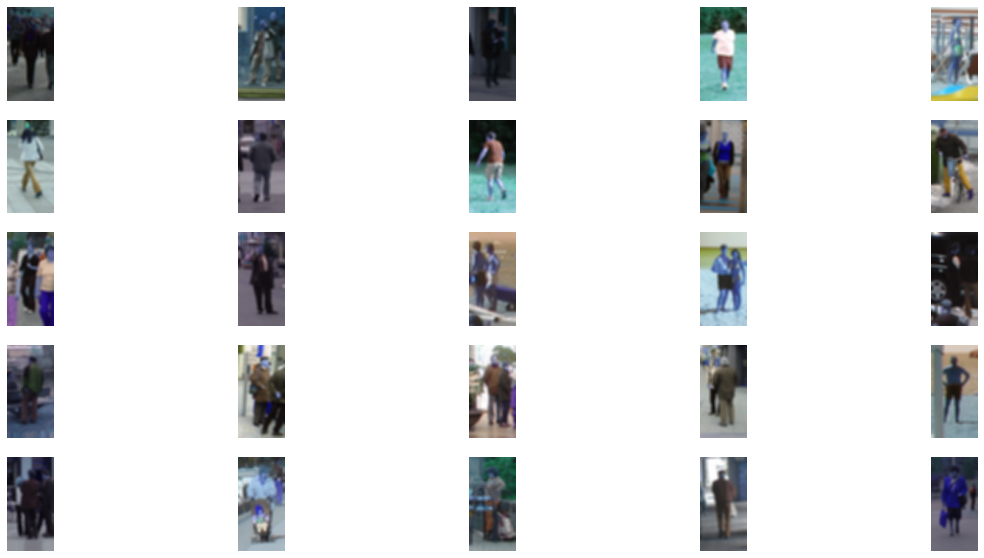

In [9]:
show_gallery(X[:], 5)

In [10]:
print(np.where(Y == 0)[0].shape)
print(X.shape)
print(Y.shape)

(12180,)
(14596, 128, 64, 3)
(14596,)


In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

## Build CNN Model

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(128, 64, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 62, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 6, 128)       0

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,)

val_datagen = ImageDataGenerator(
    rescale=1. / 255,)

In [14]:
batch_size = 100

train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(X_val, Y_val, batch_size=batch_size)

## Train Model

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(X_val) // batch_size,
    callbacks=[early_stopping_cb]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
116/116 [==============================] - 177s 2s/step - loss: 0.1367 - accuracy: 0.9477 - val_loss: 0.0045 - val_accuracy: 0.9993
Epoch 2/30
116/116 [==============================] - 170s 1s/step - loss: 0.0054 - accuracy: 0.9993 - val_loss: 0.0044 - val_accuracy: 0.9997
Epoch 3/30
116/116 [==============================] - 177s 2s/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 4/30
116/116 [==============================] - 170s 1s/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.0029 - val_accuracy: 0.9997
Epoch 5/30
116/116 [==============================] - 175s 2s/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0024 - val_accuracy: 0.9997
Epoch 6/30
116/116 [==============================] - 172s 1s/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.0024 - val_accuracy: 0.9997
Epoch 7/30
116/116 [==============================] - 171s 1s/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.0023 - val_accuracy: 0.9997

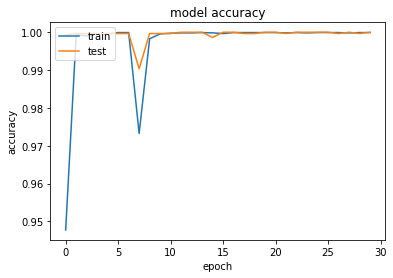

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

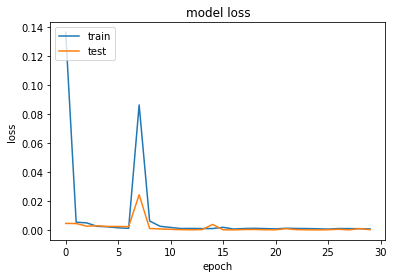

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('/content/gdrive/MyDrive/Udacity/DS_Prj_04/model_cnn_wieghts.h5')

In [ ]:
def prepare_data_test(pos_img_dir = pos_img_dir, neg_img_dir = neg_img_dir): 
  pos_img_files = os.listdir(pos_img_dir)
  neg_img_files = os.listdir(neg_img_dir)
  X = []
  Y = []
  
  for pos_img_file in pos_img_files:
    pos_filepath = pos_img_dir + pos_img_file
    pos_img = img_to_array(load_img(pos_filepath))
    pos_roi = cv2.resize(pos_img, (64, 128))
    pos_roi = cv2.GaussianBlur(pos_roi,(5,5),cv2.BORDER_DEFAULT)
    X.append(pos_roi)
    Y.append(1)

  for neg_img_file in neg_img_files:
    neg_filepath = neg_img_dir + neg_img_file
    neg_img = img_to_array(load_img(neg_filepath))
    neg_aug = ten_random_windows(neg_img)
    for neg_i in neg_aug: 
      neg_i = cv2.resize(neg_i, (64, 128))
      neg_i = cv2.GaussianBlur(neg_i,(5,5),cv2.BORDER_DEFAULT)
      X.append(neg_i)
      Y.append(0)
  return np.array(X), np.array(Y)

In [ ]:
pos_img_dir_test = r'/content/INRIAPerson/test_64x128_H96/pos/'
neg_img_dir_test = r'/content/INRIAPerson/test_64x128_H96/neg/'
X_test, Y_test = prepare_data_test(pos_img_dir = pos_img_dir_test, neg_img_dir = neg_img_dir_test)
X_test = X_test/255.0

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255,)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=batch_size)

In [ ]:
from keras.models import load_model
m = load_model('/content/gdrive/MyDrive/Udacity/DS_Prj_04/model_cnn_wieghts.h5')

In [ ]:
y_pred= m.predict(X_test)

177/177 [==============================] - 22s 121ms/step


In [ ]:
print(y_pred)

[[1.        ]
 [1.        ]
 [1.        ]
 ...
 [1.        ]
 [1.        ]
 [0.99999994]]


In [ ]:
y_prd = []
for i in y_pred:
  y_prd.append(1 if i[0]>0.7 else 0)

In [ ]:
y_prd = np.array(y_prd)
print(y_prd)

[1 1 1 ... 1 1 1]


In [ ]:
print(Y_test)

[1 1 1 ... 0 0 0]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Acurracy score: {}".format(accuracy_score(Y_test, y_prd)))
print("Precision score: {}".format(precision_score(Y_test, y_prd)))
print("Recall score: {}".format(recall_score(Y_test, y_prd)))
print("F1 score: {}".format(f1_score(Y_test, y_prd)))

Acurracy score: 0.22518544683857294
Precision score: 0.20500271886895052
Recall score: 0.9991166077738516
F1 score: 0.340201534065273


In [ ]:
print(cv2.imread(r'/content/INRIAPerson/test_64x128_H96/pos/crop001719b.png'))

None
